In [ ]:
from typing import List, Optional, Generator
from datetime import datetime, timezone, timedelta
import random
import uuid
import hashlib
import os
import math
import pickle

import numpy as np
import pandas as pd
import dask
import xgboost
import dask_xgboost
from dask.distributed import Client, progress
from pathlib import Path
import dask.dataframe as dd
from dask import delayed
from dask_ml.model_selection import train_test_split



In [ ]:
client = Client()
client

/opt/dev/anaconda3/envs/dask/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39921 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:37711 Dashboard: http://127.0.0.1:39921/status,Cluster Workers: 4 Cores: 12 Memory: 33.54 GB


In [ ]:
df = dd.read_parquet(f'./data/training/sampled/', engine='fastparquet')
df_validation = dd.read_parquet(f'./data/training/validation/', engine='fastparquet')

In [ ]:
def features_and_labels(df):
    X = df[['order_amount', 'emails_by_customer_id', 'ip_addrs_by_customer_id', 'order_amount_mean_by_customer_id',
           'order_amount_std_by_customer_id', 'order_amount_min_by_customer_id', 'order_amount_max_by_customer_id',
           'order_amount_sum_by_customer_id', 'customer_ids_by_email', 'order_amount_mean_by_email',
           'order_amount_std_by_email', 'order_amount_min_by_email', 'order_amount_max_by_email',
           'order_amount_sum_by_email']]
    y = df[['is_fraud']]
    return X, y

X, y = features_and_labels(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
y_train.groupby('is_fraud').is_fraud.count().compute()

/opt/dev/anaconda3/envs/dask/lib/python3.8/site-packages/dask_ml/model_selection/_split.py:462: FutureWarning: The default value for 'shuffle' must be specified when splitting DataFrames. In the future DataFrames will automatically be shuffled within blocks prior to splitting. Specify 'shuffle=True' to adopt the future behavior now, or 'shuffle=False' to retain the previous behavior.
  warnings.warn(


is_fraud
0    2220341
1    1763154
Name: is_fraud, dtype: int64

In [ ]:
#XGBoost
params = {'objective': 'binary:logistic',
          'max_depth': 6, 'eta': 0.01,
          'min_child_weight': 0.5, 'verbosity': 1, 'tree_method': 'hist'}
evals = {}
bst = dask_xgboost.train(client, params, X_train, y_train, num_boost_round=10, evals_result=evals, eval_set=[(X_test.compute(), y_test.compute())])
evals

/opt/dev/anaconda3/envs/dask/lib/python3.8/site-packages/distributed/worker.py:3376: UserWarning: Large object of size 95.36 MB detected in task graph: 
  {'dmatrix_kwargs': {}, 'num_boost_round': 10, 'eva ... x 1 columns])]}
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  warnings.warn(


{'validation_0': {'error': [0.221698,
   0.221698,
   0.221698,
   0.221698,
   0.221698,
   0.221698,
   0.221698,
   0.221698,
   0.221698,
   0.221698]}}

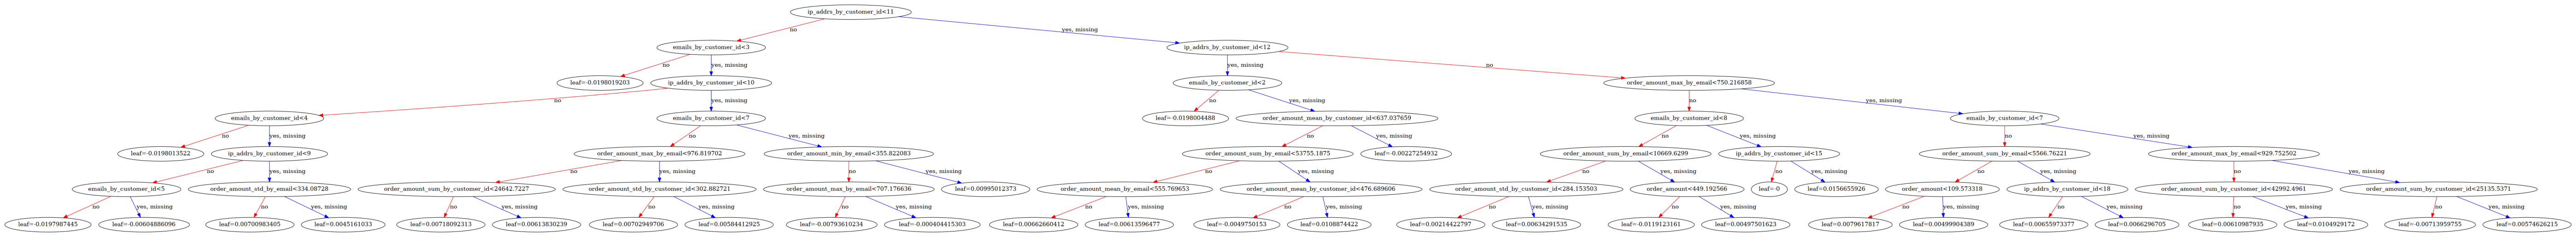

In [ ]:
import matplotlib.pyplot as plt
from xgboost import plot_tree

plot_tree(bst, num_trees=1)
fig = plt.gcf()
fig.set_size_inches(100, 100)


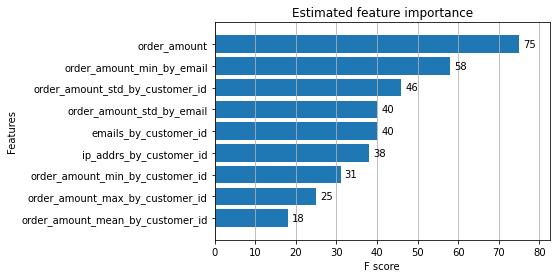

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

ax = xgboost.plot_importance(bst, height=0.8, max_num_features=9)
ax.grid(False, axis="y")
ax.set_title('Estimated feature importance')
plt.show()

In [ ]:
y_hat = dask_xgboost.predict(client, bst, X_test).persist()

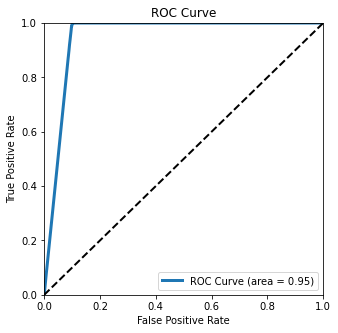

In [ ]:
from sklearn.metrics import roc_curve

y_test, y_hat = dask.compute(y_test, y_hat)
fpr, tpr, _ = roc_curve(y_test, y_hat)

from sklearn.metrics import auc

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(fpr, tpr, lw=3,
        label='ROC Curve (area = {:.2f})'.format(auc(fpr, tpr)))
ax.plot([0, 1], [0, 1], 'k--', lw=2)
ax.set(
    xlim=(0, 1),
    ylim=(0, 1),
    title="ROC Curve",
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)
ax.legend();
plt.show()

In [ ]:
from sklearn.metrics import average_precision_score, f1_score, precision_score, recall_score
f1 = f1_score(y_test, y_hat > 0.5)
precision = precision_score(y_test, y_hat > 0.5)
recall = recall_score(y_test, y_hat > 0.5)

average_precision = average_precision_score(y_test, y_hat)

print('TEST: Average precision-recall score:{0:0.2f} precision:{1: 0.2f} recall:{1: 0.2f} f1:{1: 0.2f}'.format(
      average_precision, precision, recall, f1))

treshold = 0.5
tp, tn, fp, fn = 0, 0, 0, 0
for v, p  in zip(y_test.to_numpy() > treshold, y_hat > treshold):
    if v and p: tp += 1
    elif v and not p: fn += 1
    elif not v and not p: tn += 1
    elif not v and p: fp += 1


tpr = tp/(tp+fp)
rec = tp/(tp+fn)
tnr = tn/(tn+fp)
acc = (tpr + tnr) / 2
f1 = 2*(tpr*rec)/(tpr+rec)
        
print('tp:', tp, 'tn', tn, 'fp', fp, 'fn', fn, 'prec', tpr, 'rec',rec, 'tpr', tpr, 'tnr', tnr, 'acc', acc, 'f1', f1 )

TEST: Average precision-recall score:0.67 precision: 0.66 recall: 0.66 f1: 0.66
tp: 70140 tn 319105 fp 35367 fn 332 prec 0.6647900139327249 rec 0.995288909070269 tpr 0.6647900139327249 tnr 0.9002262520029791 acc 0.782508132967852 f1 0.7971405679086708


In [ ]:
os.makedirs('./data/model/xgb/', exist_ok=True)
with open('./data/model/xgb/bst.pkl', 'wb') as fb:
    pickle.dump(bst, fb)

In [ ]:
# Validation with larger and recent data
X_valid, y_valid = features_and_labels(df_validation)
y_pred = dask_xgboost.predict(client, bst, X_valid).persist()
y_valid, y_pred = dask.compute(y_valid, y_pred)

In [ ]:
#Cross-validation
tp, tn, fp, fn = 0, 0, 0, 0
for v, p  in zip(y_valid.to_numpy() > treshold, y_pred > treshold):
    if v and p: tp += 1
    elif v and not p: fn += 1
    elif not v and not p: tn += 1
    elif not v and p: fp += 1


tpr = tp/(tp+fp)
rec = tp/(tp+fn)
tnr = tn/(tn+fp)
acc = (tpr + tnr) / 2
f1 = 2*(tpr*rec)/(tpr+rec)
        
print('tp:', tp, 'tn', tn, 'fp', fp, 'fn', fn, 'prec', tpr, 'rec',rec, 'tpr', tpr, 'tnr', tnr, 'acc', acc, 'f1', f1 )

tp: 89089 tn 814132 fp 90076 fn 490 prec 0.4972455557726118 rec 0.9945299679612409 tpr 0.4972455557726118 tnr 0.900381328189974 acc 0.6988134419812929 f1 0.663002708897687
